In [1]:
import torch
from sklearn.model_selection import train_test_split
from torch import nn
import os 
import csv
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from torch.utils.data import DataLoader, TensorDataset
from scipy.ndimage import gaussian_filter1d
from scipy.signal import find_peaks
from sklearn.metrics import confusion_matrix


from src.models import MultiClassifierV2_STN, CVAE
#from src.utils import process_spectra_data, process_spectra_csv_data

# Device Setup

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Optionally, you can print more details about the GPU if available
if torch.cuda.is_available():
    print(f"GPU Name: {torch.cuda.get_device_name(0)}")
    print(f"Number of GPUs available: {torch.cuda.device_count()}")

Using device: cuda
GPU Name: Tesla T4
Number of GPUs available: 1


## Single Model Training


In [ ]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
from src.utils import  preprocess_data_for_classifier, train_model
from src.models import STNClassifier, MLPClassifier,  CNNClassifier

max_shift = 3.0 # in eV
max_broadening_sigma = 2.0


train_loader, test_loader, input_features, output_features = preprocess_data_for_classifier(
    spectra_dir= '../data/synthetic_data_hard_final/synthetic_spectra',
    labels_dir='../data/synthetic_data_hard_final/synthetic_labels',
    max_shift=max_shift,
    max_broadening_sigma=max_broadening_sigma,
    valence_range=0,  #valence region is already removed in saved data
    energy_resolution=0.1, 
    test_size=0.2,
    random_state=42,
    batch_size=64)
# 4. Create an instance of the model and send it to target devic


model_0 =  STNClassifier().to(device)
#model_0 =  MultiClassifierV2_STN().to(device)
#model_0 =  MultiClassifierV1().to(device)
#Pielsticker_CNN().to(device)

model_path = Path("../models/STNClassifier_shift_3.0eV_model.pth")
model_0.load_state_dict(torch.load(model_path))


loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model_0.parameters(), lr=1e-4)

# Calculate accuracy (a classification metric)
def accuracy_fn(y_true, y_pred):
    # Check if all 39 classes match for each sample
    correct = (y_true == y_pred).all(axis=1).sum().item()  # Use .all(axis=1) to check all classes
    acc = (correct / len(y_true)) * 100  # Calculate accuracy as a percentage
    return acc

# Create a list to store loss values
training_loss_values = []
testing_loss_values = []

scheduler = ReduceLROnPlateau(
    optimizer,
    mode='min',      # 'min' means it looks for the metric to decrease
    factor=0.1,      # Factor by which the learning rate will be reduced (new_lr = lr * factor)
    patience=5,     # Number of epochs with no improvement after which learning rate will be reduced
    verbose=True     # Prints a message when the learning rate is updated
)

# Train the model
training_information = train_model(
    model=model_0,
    train_loader=train_loader,
    test_loader=test_loader,
    loss_fn=loss_fn,
    optimizer=optimizer,
    device=device,
    epochs=1000,
    print_freq=1, # Print every 100 epochs
    scheduler= scheduler
)

training_loss_values = training_information['train_loss']
testing_loss_values = training_information['test_loss']
trained_model = training_information['model']

/home/issa/new_project_clone/GenXPS_public/genXPS/.venv/lib/python3.13/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch:    0 | Train Loss: 0.04938, Acc: 56.25% | Test Loss: 0.03737, Acc: 65.12%
Epoch:    1 | Train Loss: 0.04791, Acc: 56.87% | Test Loss: 0.03694, Acc: 65.50%
Epoch:    2 | Train Loss: 0.04738, Acc: 57.23% | Test Loss: 0.03708, Acc: 66.05%
Epoch:    3 | Train Loss: 0.04666, Acc: 57.66% | Test Loss: 0.03619, Acc: 66.14%


KeyboardInterrupt: 

In [6]:


loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model_0.parameters(), lr=1e-4)

# Calculate accuracy (a classification metric)
def accuracy_fn(y_true, y_pred):
    # Check if all 39 classes match for each sample
    correct = (y_true == y_pred).all(axis=1).sum().item()  # Use .all(axis=1) to check all classes
    acc = (correct / len(y_true)) * 100  # Calculate accuracy as a percentage
    return acc

# Create a list to store loss values
training_loss_values = []
testing_loss_values = []

scheduler = ReduceLROnPlateau(
    optimizer,
    mode='min',      # 'min' means it looks for the metric to decrease
    factor=0.1,      # Factor by which the learning rate will be reduced (new_lr = lr * factor)
    patience=5,     # Number of epochs with no improvement after which learning rate will be reduced
    verbose=True     # Prints a message when the learning rate is updated
)

# Train the model
training_information = train_model(
    model=model_0,
    train_loader=train_loader,
    test_loader=test_loader,
    loss_fn=loss_fn,
    optimizer=optimizer,
    device=device,
    epochs=1000,
    print_freq=1, # Print every 100 epochs
    scheduler= scheduler
)

training_loss_values = training_information['train_loss']
testing_loss_values = training_information['test_loss']
trained_model = training_information['model']

Epoch:    0 | Train Loss: 0.02832, Acc: 72.88% | Test Loss: 0.02132, Acc: 79.47%
Epoch:    1 | Train Loss: 0.02821, Acc: 72.88% | Test Loss: 0.02193, Acc: 79.11%
Epoch:    2 | Train Loss: 0.02816, Acc: 72.86% | Test Loss: 0.02142, Acc: 79.58%
Epoch:    3 | Train Loss: 0.02795, Acc: 73.09% | Test Loss: 0.02129, Acc: 79.42%
Epoch:    4 | Train Loss: 0.02811, Acc: 72.86% | Test Loss: 0.02138, Acc: 79.38%
Epoch:    5 | Train Loss: 0.02796, Acc: 73.02% | Test Loss: 0.02143, Acc: 79.78%
Epoch:    6 | Train Loss: 0.02801, Acc: 72.95% | Test Loss: 0.02225, Acc: 77.98%
Epoch:    7 | Train Loss: 0.02780, Acc: 73.12% | Test Loss: 0.02115, Acc: 79.60%
Epoch:    8 | Train Loss: 0.02783, Acc: 73.06% | Test Loss: 0.02147, Acc: 79.61%
Epoch:    9 | Train Loss: 0.02777, Acc: 73.20% | Test Loss: 0.02192, Acc: 78.84%
Epoch:   10 | Train Loss: 0.02781, Acc: 73.07% | Test Loss: 0.02110, Acc: 79.56%
Epoch:   11 | Train Loss: 0.02766, Acc: 73.31% | Test Loss: 0.02072, Acc: 79.90%
Epoch:   12 | Train Loss: 0.

TypeError: tuple indices must be integers or slices, not str

# Train STN using pretrained MLP (trained on unshifted data)

In [11]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
from src.utils import  preprocess_data_for_classifier, train_model
from src.models import STNClassifier, MLPClassifier,  CNNClassifier

max_shift = 3.0 # in eV
max_broadening_sigma = 2.0


train_loader, test_loader, input_features, output_features = preprocess_data_for_classifier(
    spectra_dir= '../data/synthetic_data_hard_final/synthetic_spectra',
    labels_dir='../data/synthetic_data_hard_final/synthetic_labels',
    max_shift=max_shift,
    max_broadening_sigma=max_broadening_sigma,
    valence_range=0,  #valence region is already removed in saved data
    energy_resolution=0.1, 
    test_size=0.2,
    random_state=42,
    batch_size=64)
# 4. Create an instance of the model and send it to target device

stn_model =  STNClassifier().to(device)


pretrained_mlp_model_path = Path("../models/mlp_expert_weights.pth")
stn_model.classifier.load_state_dict(torch.load(pretrained_mlp_model_path))

loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(stn_model.parameters(), lr=1e-4)

# Calculate accuracy (a classification metric)
def accuracy_fn(y_true, y_pred):
    # Check if all 39 classes match for each sample
    correct = (y_true == y_pred).all(axis=1).sum().item()  # Use .all(axis=1) to check all classes
    acc = (correct / len(y_true)) * 100  # Calculate accuracy as a percentage
    return acc

# Create a list to store loss values
training_loss_values = []
testing_loss_values = []

scheduler = ReduceLROnPlateau(
    optimizer,
    mode='min',      # 'min' means it looks for the metric to decrease
    factor=0.1,      # Factor by which the learning rate will be reduced (new_lr = lr * factor)
    patience=5,     # Number of epochs with no improvement after which learning rate will be reduced
    verbose=True     # Prints a message when the learning rate is updated
)

# Train the model
training_information = train_model(
    model=stn_model,
    train_loader=train_loader,
    test_loader=test_loader,
    loss_fn=loss_fn,
    optimizer=optimizer,
    device=device,
    epochs=1000,
    print_freq=1, # Print every 100 epochs
    scheduler= scheduler
)

training_loss_values = training_information['train_loss']
testing_loss_values = training_information['test_loss']
trained_model = training_information['model']

Epoch:    0 | Train Loss: 0.16823, Acc: 22.89% | Test Loss: 0.05580, Acc: 55.37%
Epoch:    1 | Train Loss: 0.06065, Acc: 50.63% | Test Loss: 0.04141, Acc: 63.43%
Epoch:    2 | Train Loss: 0.05123, Acc: 55.97% | Test Loss: 0.03674, Acc: 66.77%
Epoch:    3 | Train Loss: 0.04639, Acc: 58.99% | Test Loss: 0.03439, Acc: 68.95%
Epoch:    4 | Train Loss: 0.04382, Acc: 60.71% | Test Loss: 0.03274, Acc: 69.72%
Epoch:    5 | Train Loss: 0.04204, Acc: 62.16% | Test Loss: 0.03389, Acc: 68.52%
Epoch:    6 | Train Loss: 0.04025, Acc: 63.12% | Test Loss: 0.03205, Acc: 69.97%
Epoch:    7 | Train Loss: 0.03903, Acc: 64.19% | Test Loss: 0.03014, Acc: 71.69%
Epoch:    8 | Train Loss: 0.03843, Acc: 64.54% | Test Loss: 0.02936, Acc: 72.10%
Epoch:    9 | Train Loss: 0.03762, Acc: 65.18% | Test Loss: 0.03109, Acc: 70.42%
Epoch:   10 | Train Loss: 0.03712, Acc: 65.63% | Test Loss: 0.02930, Acc: 72.78%
Epoch:   11 | Train Loss: 0.03637, Acc: 66.21% | Test Loss: 0.02695, Acc: 74.61%
Epoch:   12 | Train Loss: 0.

TypeError: tuple indices must be integers or slices, not str

# Variable-shift Looper


this loops performs training for models on data at different levels of shift applied. This provides a good point of comparison for how different models can handle horizontal shifts 

In [8]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
from src.utils import  preprocess_data_for_classifier, train_model
from src.models import STNClassifier, MLPClassifier, CNNClassifier


output_filename = 'shift_experiment_results.csv'

shift_values = [0.0] 
# shift_values = [1.0] 
max_broadening_sigma = 2.0

all_model_classes = {
    'STNClassifier': STNClassifier,
    'MLPClassifier': MLPClassifier,
    'CNNClassifier': CNNClassifier
}

models_to_run = [
    'MLPClassifier',
]

# List to store results from all runs
results_list = []


print("Starting shift robustness experiment...")
print("=" * 40)

for model_name in models_to_run:
    print(f"\n--- Testing Model: {model_name} ---")
     # --- Step 2: Initialize a Fresh Model and Optimizer ---
    # A new, untrained model is created for each experiment run.
    model_class = all_model_classes[model_name]
    model = model_class().to(device)
    loss_fn = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

    
    for shift_value in shift_values:
        max_shift = shift_value

        train_loader, test_loader, input_features, output_features = preprocess_data_for_classifier(
            spectra_dir= '../data/synthetic_data_hard_final/synthetic_spectra',
            labels_dir='../data/synthetic_data_hard_final/synthetic_labels',
            max_shift=max_shift,
            max_broadening_sigma=max_broadening_sigma,
            valence_range=0,  #valence region is already removed in saved data
            energy_resolution=0.1, 
            test_size=0.2,
            random_state=42,
            batch_size=64)

        
        scheduler = ReduceLROnPlateau(
            optimizer,
            mode='min',      # 'min' means it looks for the metric to decrease
            factor=0.1,      # Factor by which the learning rate will be reduced (new_lr = lr * factor)
            patience=10,     # Number of epochs with no improvement after which learning rate will be reduced
            verbose=True     # Prints a message when the learning rate is updated
        )

        # Train the model
        history_dict, model = train_model(
            model=model,
            train_loader=train_loader,
            test_loader=test_loader,
            loss_fn=loss_fn,
            optimizer=optimizer,
            device=device,
            epochs=200,
            print_freq=5, # Print every 100 epochs
            scheduler= scheduler
        )
        
        # --- Step 4: Extract and Save Results ---
        best_loss = min(history_dict['test_loss'])
        best_accuracy = max(history_dict['test_acc'])
        
        # Create a dictionary for just the current run's result
        current_result = {
            'model': model_name,
            'max_shift':  max_shift,
            'best_test_loss': best_loss,
            'best_test_accuracy': best_accuracy
        }
        
        # Convert the single result to a DataFrame
        result_df_to_append = pd.DataFrame([current_result])
        
        # Check if the file already exists to decide whether to write the header
        file_exists = os.path.exists(output_filename)
        
        # Append the new result to the CSV file
        result_df_to_append.to_csv(
            output_filename,
            mode='a',          # 'a' for append
            header=not file_exists, # Write header only if file doesn't exist
            index=False
        )
        
        print(f"  Done. Best Accuracy: {best_accuracy:.2f}% | Best Loss: {best_loss:.4f}")
        print(f"  Results appended to {output_filename}")

        if shift_value == 0.0:
        # Save the model state for the 3.0 eV shift case
            model_save_path = f"{model_name}_shift_{shift_value}eV_model.pth"
            torch.save(model.state_dict(), model_save_path)
            print(f"  Model state saved to {model_save_path}")
        

# ==============================================================================
# 3. FINAL SUMMARY
# ==============================================================================

print("\nExperiment complete.")
if os.path.exists(output_filename):
    final_results_df = pd.read_csv(output_filename)
    print("\n--- Final Results Summary ---")
    print(final_results_df)

Starting shift robustness experiment...

--- Testing Model: MLPClassifier ---


/home/issa/new_project_clone/GenXPS_public/genXPS/.venv/lib/python3.13/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch:    0 | Train Loss: 0.22579, Acc: 17.09% | Test Loss: 0.11057, Acc: 24.79%
Epoch:    5 | Train Loss: 0.04779, Acc: 57.46% | Test Loss: 0.03972, Acc: 64.41%
Epoch:   10 | Train Loss: 0.03907, Acc: 64.41% | Test Loss: 0.03387, Acc: 68.52%
Epoch:   15 | Train Loss: 0.03534, Acc: 67.58% | Test Loss: 0.02805, Acc: 73.61%
Epoch:   20 | Train Loss: 0.03286, Acc: 69.58% | Test Loss: 0.02708, Acc: 74.40%
Epoch:   25 | Train Loss: 0.03142, Acc: 70.83% | Test Loss: 0.02469, Acc: 76.89%
Epoch:   30 | Train Loss: 0.02999, Acc: 72.16% | Test Loss: 0.02370, Acc: 77.81%
Epoch:   35 | Train Loss: 0.02914, Acc: 72.95% | Test Loss: 0.02251, Acc: 78.81%
Epoch:   40 | Train Loss: 0.02798, Acc: 73.90% | Test Loss: 0.02206, Acc: 79.36%
Epoch:   45 | Train Loss: 0.02732, Acc: 74.49% | Test Loss: 0.02148, Acc: 79.59%
Epoch:   50 | Train Loss: 0.02668, Acc: 74.92% | Test Loss: 0.02059, Acc: 80.45%
Epoch:   55 | Train Loss: 0.02612, Acc: 75.41% | Test Loss: 0.02044, Acc: 80.94%
Epoch:   60 | Train Loss: 0.

## Producing a Learning Curve


i.e finding the minimum dataset size required for training 


Starting learning curve generation...
------------------------------
--- Training with 80000 samples (100%) ---
Epoch:    0 | Train Loss: 0.25690, Acc: 5.97% | Test Loss: 0.15257, Acc: 11.39%

Best performance at epoch 122 with Test Loss: 0.02910
Best test loss: 0.0291 | Best test accuracy: 72.75%

--- Training with 64000 samples (80%) ---
Epoch:    0 | Train Loss: 0.27457, Acc: 5.55% | Test Loss: 0.16246, Acc: 10.17%

Best performance at epoch 128 with Test Loss: 0.03086
Best test loss: 0.0309 | Best test accuracy: 71.60%

--- Training with 48000 samples (60%) ---
Epoch:    0 | Train Loss: 0.31037, Acc: 4.38% | Test Loss: 0.18474, Acc: 7.58%

Best performance at epoch 127 with Test Loss: 0.03299
Best test loss: 0.0330 | Best test accuracy: 69.79%

--- Training with 32000 samples (40%) ---
Epoch:    0 | Train Loss: 0.36710, Acc: 3.38% | Test Loss: 0.22287, Acc: 5.24%

Best performance at epoch 127 with Test Loss: 0.03854
Best test loss: 0.0385 | Best test accuracy: 64.58%

--- Training

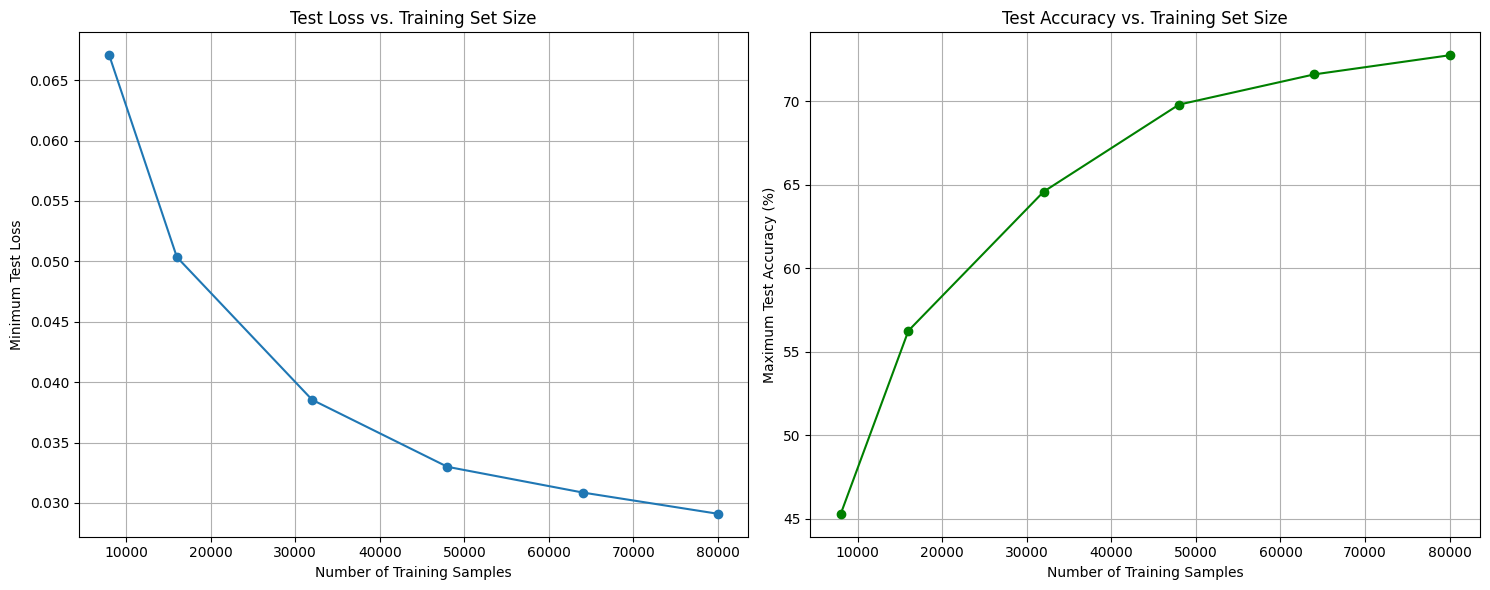

In [ ]:
from torch.utils.data import DataLoader, random_split

# ==============================================================================
# 2. LEARNING CURVE GENERATION WORKFLOW
# ==============================================================================

# Define the fractions of the training data to use
training_fractions = [1.0, 0.8, 0.6, 0.4, 0.2, 0.1]
full_train_dataset = train_loader.dataset
num_total_train_samples = len(full_train_dataset)

# Lists to store the final results for plotting
best_test_losses = []
best_test_accuracies = [] # Assuming accuracy is also returned by train_model
subset_sizes = []

print("Starting learning curve generation...")
print("-" * 30)

# Loop over the different training set sizes
for fraction in training_fractions:
    # --- Step 1: Subsample the Training Data ---
    subset_size = int(num_total_train_samples * fraction)
    
    # Create a random subset of the full training dataset
    subset_dataset, _ = random_split(
        full_train_dataset, 
        [subset_size, num_total_train_samples - subset_size],
        generator=torch.Generator().manual_seed(42) # for reproducible splits
    )
    
    # Create a new DataLoader for this smaller training subset
    subset_train_loader = DataLoader(subset_dataset, batch_size=train_loader.batch_size, shuffle=True)
    
    subset_sizes.append(subset_size)
    print(f"--- Training with {subset_size} samples ({fraction*100:.0f}%) ---")

    # --- Step 2: Train a Fresh Model ---
    # Re-initialize the model and optimizer for each run to ensure independence
    model = STNClassifier(input_features, output_features).to(device)
    loss_fn = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)

    # Train the model on the current subset
    training_history, _ = train_model(
        model=model,
        train_loader=subset_train_loader,
        test_loader=test_loader, # Always use the same full test loader
        loss_fn=loss_fn,
        optimizer=optimizer,
        device=device,
        epochs=130, # Use a consistent number of epochs
        print_freq=10 # Adjust as needed
    )

    # --- Step 3: Record the Best Performance (FIXED) ---
    # This section is updated to handle a TUPLE return from train_model.
    # We assume the return format is (train_loss_history, test_loss_history, test_acc_history, ...etc)
    
    # Access the test loss history list by its index (e.g., 1)
    test_loss_history = training_history['test_loss']
    best_loss_this_run = min(test_loss_history)
    best_test_losses.append(best_loss_this_run)
    
    # Access the test accuracy history list by its index (e.g., 2)
    test_acc_history = training_history['test_acc']
    best_acc_this_run = max(test_acc_history)
    best_test_accuracies.append(best_acc_this_run)
    
    print(f"Best test loss: {best_loss_this_run:.4f} | Best test accuracy: {best_acc_this_run:.2f}%\n")


# --- Step 4: Plot the Final Curve ---
print("Plotting learning curves...")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot Test Loss
ax1.plot(subset_sizes, best_test_losses, marker='o', linestyle='-')
ax1.set_title('Test Loss vs. Training Set Size')
ax1.set_xlabel('Number of Training Samples')
ax1.set_ylabel('Minimum Test Loss')
ax1.grid(True)

# Plot Test Accuracy
ax2.plot(subset_sizes, best_test_accuracies, marker='o', linestyle='-', color='g')
ax2.set_title('Test Accuracy vs. Training Set Size')
ax2.set_xlabel('Number of Training Samples')
ax2.set_ylabel('Maximum Test Accuracy (%)')
ax2.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd

# --- Step 5: Save the Learning Curve Data to a CSV File ---

print("Saving learning curve data to CSV...")

# Create a dictionary with the data to be saved.
# The keys will become the column headers in the CSV.
learning_curve_data = {
    'training_samples': subset_sizes,
    'min_test_loss': best_test_losses,
    'max_test_accuracy': best_test_accuracies
}

# Convert the dictionary into a pandas DataFrame.
results_df = pd.DataFrame(learning_curve_data)

# Define the filename for the output CSV.
output_filename = '../final_results/learning_curve_data.csv'

# Save the DataFrame to a CSV file.
# The index=False argument prevents pandas from writing row numbers.
results_df.to_csv(output_filename, index=False)

print(f"Data successfully saved to {output_filename}")

# Display the DataFrame to confirm its contents.
print("\n--- Saved Data ---")
print(results_df)


Saving learning curve data to CSV...
Data successfully saved to ../final_results/learning_curve_data.csv

--- Saved Data ---
   training_samples  min_test_loss  max_test_accuracy
0             80000       0.029101             72.745
1             64000       0.030862             71.600
2             48000       0.032991             69.790
3             32000       0.038538             64.580
4             16000       0.050353             56.250
5              8000       0.067064             45.285


# Old Training looper

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from pathlib import Path
import os
from tqdm.notebook import tqdm
import json
from src.utils import process_spectra_data, train_model, compute_class_metrics, get_label_dict 

# ==============================================================================
# 🚀 SECTION 1: HELPER FUNCTIONS & CLASSES
# (Moved from previous cells to make this script self-contained)
# ==============================================================================

class FocalLoss(nn.Module):
    """
    Focal Loss, a modification of BCE Loss for class imbalance.
    """
    def __init__(self, gamma=2, alpha=0.25):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha
    
    def forward(self, inputs, targets):
        BCE_loss = nn.BCEWithLogitsLoss(reduction='none')(inputs, targets)
        pt = torch.exp(-BCE_loss)  # Probabilities for the correct class
        F_loss = self.alpha * (1 - pt) ** self.gamma * BCE_loss  # Focal loss term
        return F_loss.mean()

def accuracy_fn(y_true, y_pred):
    """
    Calculates exact match accuracy for multi-label classification.
    """
    # Check if all classes match for each sample
    correct = (y_true == y_pred).all(axis=1).sum().item()
    acc = (correct / len(y_true)) * 100  # Accuracy as a percentage
    return acc

def init_weights(m):
    """
    Applies Kaiming Normal initialization to Conv1d and Linear layers.
    """
    if isinstance(m, nn.Conv1d) or isinstance(m, nn.Linear):
        nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
        if m.bias is not None:
            nn.init.zeros_(m.bias)



# ==============================================================================
# ⚙️ SECTION 2: CONFIGURATION
# ==============================================================================

# --- Experiment Setup ---
model_name = 'STN_Classifier_Final' # A descriptive name for this run
# Select the model architecture you want to use
selected_model_class = MultiClassifierV2_STN 
# Define the output directory for all reports and results
report_dir = Path(f'../reports/final_results/{model_name}_results')

# --- Hyperparameters ---
# You can choose which loss function to use here
loss_fn = nn.BCEWithLogitsLoss() 
# loss_fn = FocalLoss() # <-- Or uncomment this to use Focal Loss

LEARNING_RATE = 1e-4
EPOCHS = 1000
PRINT_FREQ = 1 # Print progress every 100 epochs

# --- Data Parameters ---
# Define the shift values (in eV) you want to loop over
shift_values = [0.0, 1.0, 2.0, 3.0] 
max_broadening_sigma = 0.01

# --- Get the list of Functional Group names (ensure FG_list is defined in your utils) ---
with open("../data/FG_list.json", "r") as f:
    FG_list = json.load(f)

# ==============================================================================
# 🚀 SECTION 3: MAIN EXPERIMENT WORKFLOW
# ==============================================================================

# Create the main report directory
report_dir.mkdir(parents=True, exist_ok=True)
# Initialize a list to store the summary results from each run
all_run_summaries = []
# Set the device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

# --- Main loop over different experimental conditions (shifts) ---
for max_shift in shift_values:
    print(f"\n{'='*60}")
    print(f"STARTING EXPERIMENT: max_shift = {max_shift} eV")
    print(f"{'='*60}")
    
    # 1. Process data for the current shift value
    print("Loading and processing data...")
    train_loader, test_loader, _, _ = process_spectra_data(
        spectra_dir= '../data/synthetic_data_hard_final/synthetic_spectra',
        labels_dir='../data/synthetic_data_hard_final/synthetic_labels',
        max_shift=max_shift,
        max_broadening_sigma=max_broadening_sigma,
        valence_range=0, # Assumes valence region is already removed
        energy_resolution=0.1,
        test_size=0.2,
        random_state=42,
        batch_size=64
    )
    
    # 2. Initialize model and optimizer for this run
    print("Initializing model...")
    model = selected_model_class().to(device)
    model.apply(init_weights) # Apply weight initialization
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
    
    # 3. Train the model
    print("Starting model training...")
    training_info = train_model(
        model=model,
        train_loader=train_loader,
        test_loader=test_loader,
        loss_fn=loss_fn,
        optimizer=optimizer,
        device=device,
        epochs=EPOCHS,
        print_freq=PRINT_FREQ
    )


Using device: cuda

STARTING EXPERIMENT: max_shift = 0.0 eV
Loading and processing data...
Initializing model...
Starting model training...
Epoch:    0 | Train Loss: 0.30362, Acc: 0.71% | Test Loss: 0.62198, Acc: 2.44%
Epoch:    1 | Train Loss: 0.21245, Acc: 0.81% | Test Loss: 0.51351, Acc: 0.84%
Epoch:    2 | Train Loss: 0.20941, Acc: 0.78% | Test Loss: 0.67498, Acc: 0.25%
Epoch:    3 | Train Loss: 0.20813, Acc: 0.75% | Test Loss: 0.75883, Acc: 1.05%
Epoch:    4 | Train Loss: 0.20749, Acc: 0.76% | Test Loss: 0.88050, Acc: 1.05%
Epoch:    5 | Train Loss: 0.20698, Acc: 0.75% | Test Loss: 0.59747, Acc: 0.30%


KeyboardInterrupt: 

# Save the Model

In [ ]:
# Save the model
model_path = Path("/home/issa/new_project_clone/local_models") / f"best_STN_{max_shift}_shift.pth"
torch.save(model_0.state_dict(), model_path)
print(f"Model saved to {model_path}")


Model saved to /home/issa/new_project_clone/local_models/best_STN_5_shift.pth


## Load Saved Model

In [ ]:
# Create an instance of your model
saved_model = MultiClassifierV1_STN().to(device)

# Define the path to the saved model
model_path = Path("/home/issa/new_project_clone/local_models") / f"STN_{max_shift}_shift.pth"

# Load the state dictionary
saved_model.load_state_dict(torch.load(model_path))

# Set the model to evaluation mode (if you're going to use it for inference)
saved_model.eval()

print(f"Model loaded from {model_path}")

Model loaded from /home/issa/new_project_clone/local_models/STN_3_shift.pth


## Testing

In [ ]:

def print_class_confusion_matrices(y_true, y_pred, class_names=None):
    """
    Print normalized confusion matrices for each class individually,
    handling cases where classes might be empty.
    
    Args:
        y_true: True labels (n_samples × n_classes)
        y_pred: Predicted labels (n_samples × n_classes)
        class_names: Optional list of class names
    """
    n_classes = y_true.shape[1]
    if class_names is None:
        class_names = [f"Class {i}" for i in range(n_classes)]
    
    # Initialize DataFrame to store performance metrics
    metrics_df = pd.DataFrame(columns=['Class', 'TP', 'TN', 'FP', 'FN', 
                                     'Precision', 'Recall', 'F1', 'Support'])
    
    for i in range(n_classes):
        # Ensure we always consider both classes (0 and 1) even if empty
        cm = confusion_matrix(y_true[:, i], y_pred[:, i], labels=[0, 1])
        
        # Calculate metrics
        tn, fp, fn, tp = cm.ravel()
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        support = tp + fn
        
        # Store metrics
        metrics_df.loc[i] = [
            class_names[i],
            tp, tn, fp, fn,
            f"{precision:.3f}",
            f"{recall:.3f}",
            f"{f1:.3f}",
            support
        ]
        
        # Normalize by true labels (rows)
        cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
        
        print(f"\n{class_names[i]} Confusion Matrix (Normalized by True Labels):")
        print(f"Actual\Predicted | Negative | Positive")
        print("-"*40)
        print(f"Negative         | {cm_normalized[0,0]:5.1f}%   | {cm_normalized[0,1]:5.1f}%")
        print(f"Positive         | {cm_normalized[1,0]:5.1f}%   | {cm_normalized[1,1]:5.1f}%")
    
    # Print summary metrics
    print("\n\nClassification Metrics Summary:")
    print(metrics_df.to_string(index=False))
    
    return metrics_df

<>:44: SyntaxWarning: invalid escape sequence '\P'
<>:44: SyntaxWarning: invalid escape sequence '\P'
/tmp/ipykernel_2562669/566775622.py:44: SyntaxWarning: invalid escape sequence '\P'
  print(f"Actual\Predicted | Negative | Positive")


In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score

metrics = print_class_confusion_matrices(
    y_true=test_labels_np,
    y_pred=test_preds_np,
    class_names= FG_list  # Custom names if available
)


alkene Confusion Matrix (Normalized by True Labels):
Actual\Predicted | Negative | Positive
----------------------------------------
Negative         |  99.6%   |   0.4%
Positive         |  22.8%   |  77.2%

alkyne Confusion Matrix (Normalized by True Labels):
Actual\Predicted | Negative | Positive
----------------------------------------
Negative         | 100.0%   |   0.0%
Positive         |   nan%   |   nan%

benzene ring Confusion Matrix (Normalized by True Labels):
Actual\Predicted | Negative | Positive
----------------------------------------
Negative         |  99.0%   |   1.0%
Positive         |   4.3%   |  95.7%

naphthalene Confusion Matrix (Normalized by True Labels):
Actual\Predicted | Negative | Positive
----------------------------------------
Negative         | 100.0%   |   0.0%
Positive         |  12.2%   |  87.8%

amine Confusion Matrix (Normalized by True Labels):
Actual\Predicted | Negative | Positive
----------------------------------------
Negative         |  99.9

/tmp/ipykernel_2562669/566775622.py:41: RuntimeWarning: invalid value encountered in divide
  cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
/tmp/ipykernel_2562669/566775622.py:41: RuntimeWarning: invalid value encountered in divide
  cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
/tmp/ipykernel_2562669/566775622.py:41: RuntimeWarning: invalid value encountered in divide
  cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
/tmp/ipykernel_2562669/566775622.py:41: RuntimeWarning: invalid value encountered in divide
  cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
/tmp/ipykernel_2562669/566775622.py:41: RuntimeWarning: invalid value encountered in divide
  cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
/tmp/ipykernel_2562669/566775622.py:41: RuntimeWarning: invalid value encountered in divide
  cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 10

# Testing

In [ ]:
# 4. Create an instance of the model and send it to target device
model_0 = MultiClassifierV1().to(device)

# Load the saved model
model_path = Path("../models/multi_class_models/no_shift_v0.pth")
model_0.load_state_dict(torch.load(model_path))
model_0.eval()

X_test = X_test.to(device)

# Generate predictions using the loaded model
with torch.inference_mode():
    test_logits = model_0(X_test).squeeze() 
    test_pred = torch.round(torch.sigmoid(test_logits))


FileNotFoundError: [Errno 2] No such file or directory: '../models/multi_class_models/no_shift_v0.pth'

In [ ]:
model_0.eval()

X_test = X_test.to(device)

# Generate predictions using the loaded model
with torch.inference_mode():
    test_logits = model_0(X_test).squeeze() 
    test_pred = torch.round(torch.sigmoid(test_logits))

In [ ]:
from sklearn.metrics import recall_score
import numpy as np
import os
import pandas as pd 
from tabulate import tabulate

def get_label_dict(path_to_file):
    '''
    Extract the list of functional groups
    '''
    spreadsheet_f = pd.ExcelFile(path_to_file)
    df_f = pd.read_excel(spreadsheet_f)
    return list(df_f['Functional groups'])

data_path = Path("../data/experimental_data")
CEL_FG_path = os.path.join(data_path, 'cellulose (CEL)', 'CEL_FG.xlsx')
FG_list = get_label_dict(CEL_FG_path)
FG_list.append('alkane')

y_test_np = y_test.cpu().numpy()
test_pred_np = test_pred.cpu().numpy()

report_array = []  # New array for sensitivity values

# Calculate sensitivity for each class and total frequency
for i in range(39):  # Assuming 39 classes
    # Check if the class has positive samples in the test data
    if np.sum(y_test_np[:, i]) > 0:  # If there are positive samples
        sensitivity = recall_score(y_test_np[:, i], test_pred_np[:, i], average=None)
        total_frequency = np.sum(bin_label_array[:, i])  # Count total occurrences of the class in the training data
        report_array.append([i, FG_list[i], sensitivity[1], total_frequency])  # Append class index, sensitivity value, total frequency, and functional group
    else:
        report_array.append([i, FG_list[i], None, 0])  # No sensitivity value for this class, frequency is 0, and functional group

# Calculate the average sensitivity value, ignoring empty entries
sensitivity_values = [row[2] for row in report_array if row[2] is not None]
average_sensitivity = np.mean(sensitivity_values)
    

print(tabulate(report_array, headers=['Class No.', 'Functional Group', 'Sensitivity', 'Total Frequency', ]))
print(f"\nAverage sensitivity (excluding classes with no data): {average_sensitivity:.2f}")

pd.DataFrame(report_array, columns=['Class No.', 'Functional Group', 'Sensitivity', 'Total Frequency']).to_csv('../reports/model0.csv', index=False)





  Class No.  Functional Group       Sensitivity    Total Frequency
-----------  -------------------  -------------  -----------------
          0  alkene                    0.856716               1739
          1  alkyne                                              0
          2  benzene ring              0.96881                8039
          3  naphthalene               0.75                    361
          4  amine                     0.949533               2569
          5  alcohol (aromatic)        0.793103                375
          6  alcohol (aliphatic)       0.840125               1448
          7  ether (aromatic)          0.938017               2471
          8  ether (aliphatic)         0.953913               5476
          9  alkyl halide (F)          0.989362               1882
         10  alkyl halide (Cl)         0.988764               1405
         11  alkyl halide (Br)                                   0
         12  alkyl halide (I)                                 